In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("archives/creditcard.csv")

In [3]:
df.head(2)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [5]:
df["Class"].unique()

array([0, 1], dtype=int64)

<Axes: >

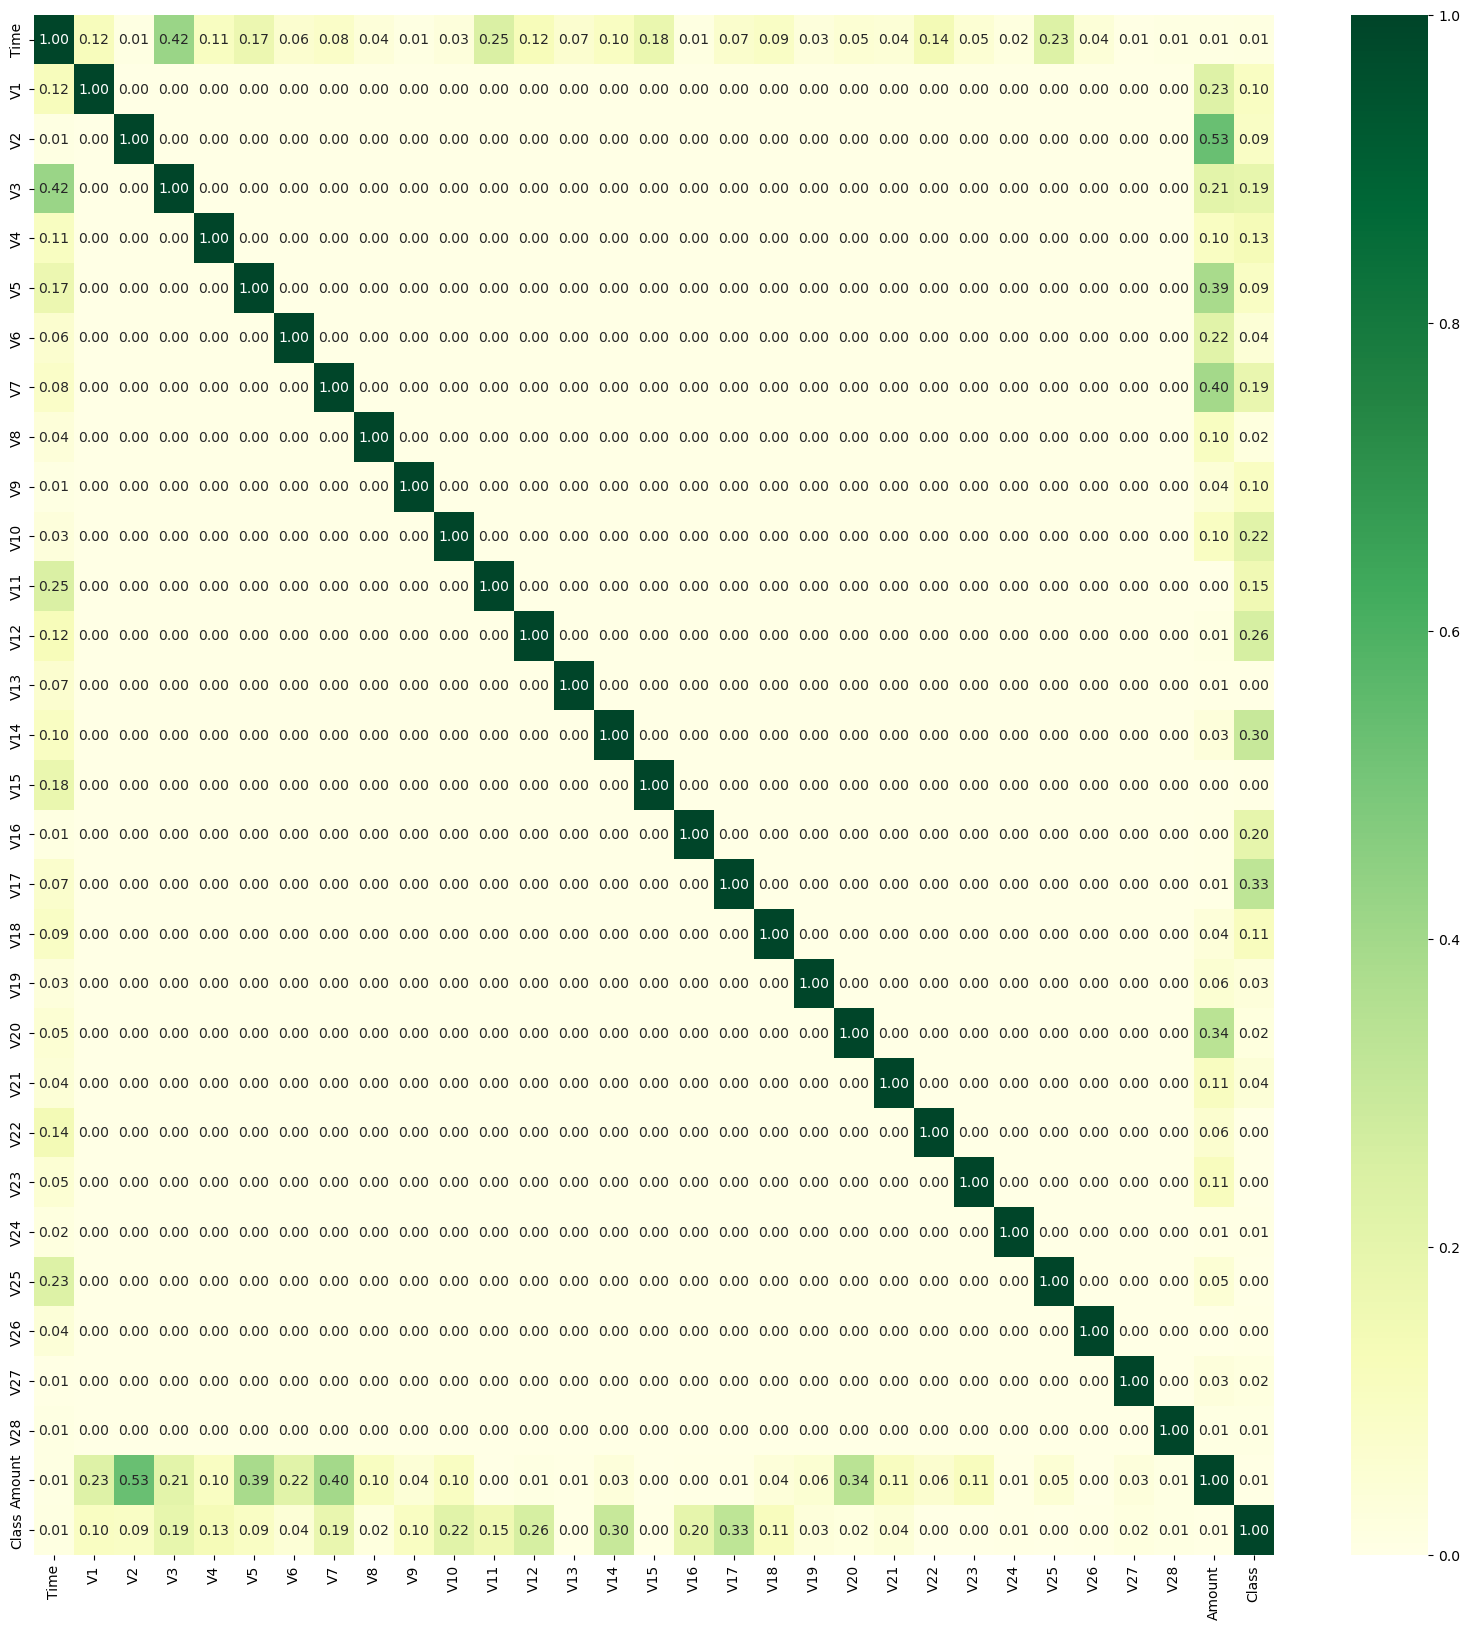

In [6]:
matrix = df.corr()

plt.figure(figsize=(20,20))
sns.heatmap(np.abs(matrix), annot=True, cmap='YlGn', fmt='0.2f')

In [7]:
# Eliminamos las columnas que menor correlación tengan
corr = 0.1
df_clean = df[matrix[(matrix['Class'] > corr) | (matrix['Class'] < -corr)].index]

Fraudes: 20.0%	Normal: 80.0%


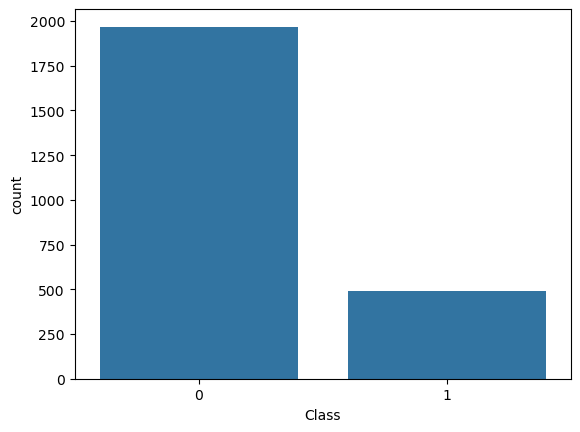

In [8]:
# En este dataset hay demasiados valores que no son fraudes por ende me quiero quedar 
# con una relación de 20% fraudes - 80% normales
fraud = df_clean[df_clean['Class'] == 1]
normal = df_clean[df_clean['Class'] == 0].sample(int(len(fraud)*4), random_state=42)

df_final = pd.concat([fraud,normal])
sns.countplot(data=df_final,x='Class')

print(f"Fraudes: {len(fraud)*100/len(df_final)}%\tNormal: {len(normal)*100/len(df_final)}%")

In [9]:
df_r=df_final.sample(frac=1,random_state=42,replace=True)
X = df_r.drop('Class',axis=1)
Y = df_r['Class']

In [10]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X_scl = StandardScaler().fit_transform(X)
X_pca = PCA(n_components=0.95).fit_transform(X_scl)

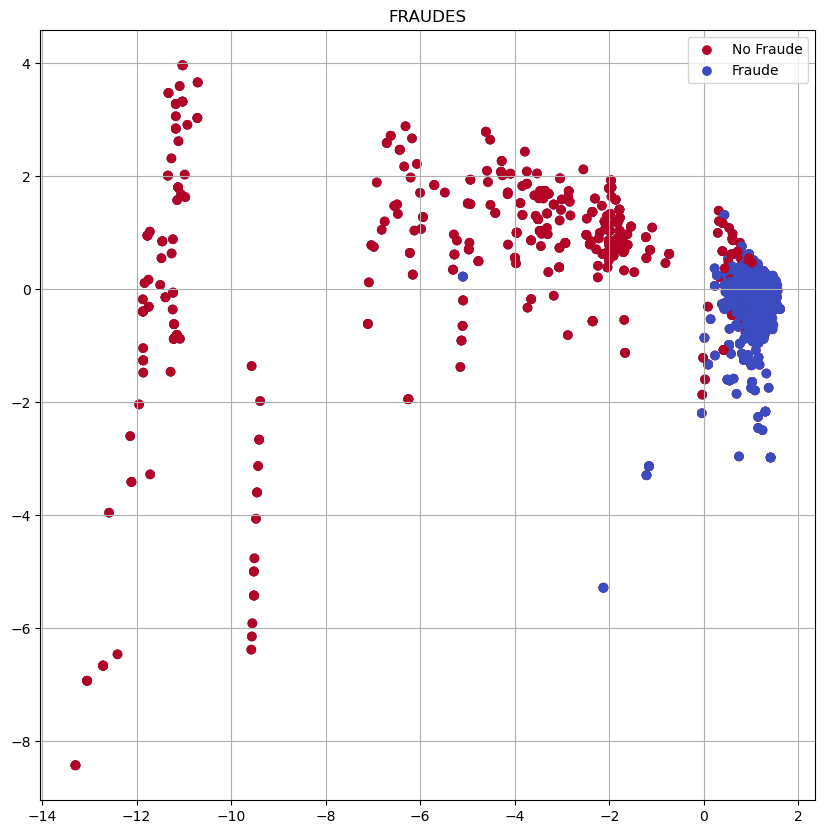

In [11]:
plt.figure(figsize=(10,10))

plt.scatter(X_pca[:,0], X_pca[:,1], c = (Y ==0 ), label = "No Fraude", 
            linewidth=1, cmap = "coolwarm")
plt.scatter(X_pca[:,0], X_pca[:,1], c = (Y ==1 ), label = "Fraude", 
            linewidth=1, cmap = "coolwarm")
plt.title("FRAUDES")
plt.grid(True)
plt.legend()

In [12]:
from sklearn.cluster import KMeans

k = 5
kmeans = KMeans(n_clusters = k, random_state = 42, n_init = 10)
# El primer : significa coger todas las filas y el ,:2 de esas filas las dos primeras columnas
data = kmeans.fit(X_pca[:,:2]) 
data

KMeans(n_clusters=5, n_init=10, random_state=42)

In [13]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=8)

def plot_centroids(centroids,  circle_color='w', cross_color='k'):
    plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=2, linewidths=12, color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    resolution=1000
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution), 
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),  cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),  linewidths=1, colors='k')
    plot_data(X)
    plot_centroids(clusterer.cluster_centers_)

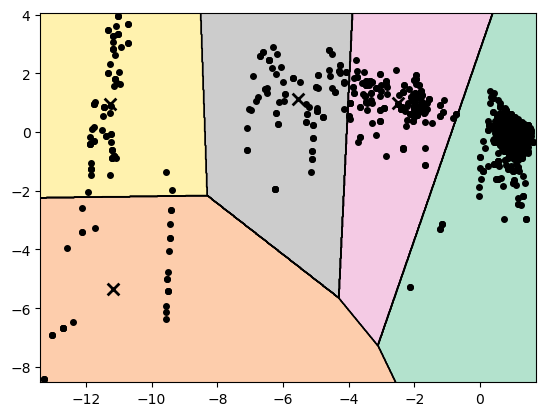

In [14]:
plot_decision_boundaries(kmeans, X_pca[:,:2])

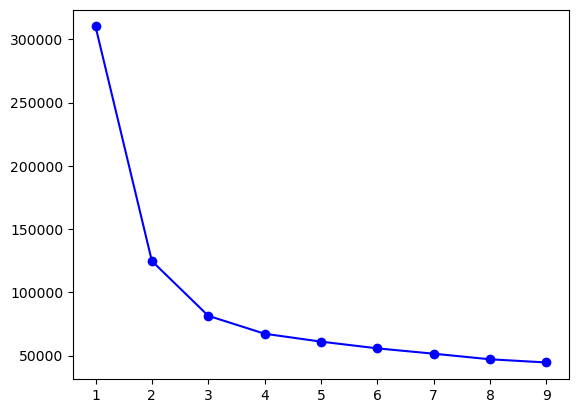

In [15]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42, n_init=10).fit(X)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

plt.plot(range(1, 10), inertias, "bo-")

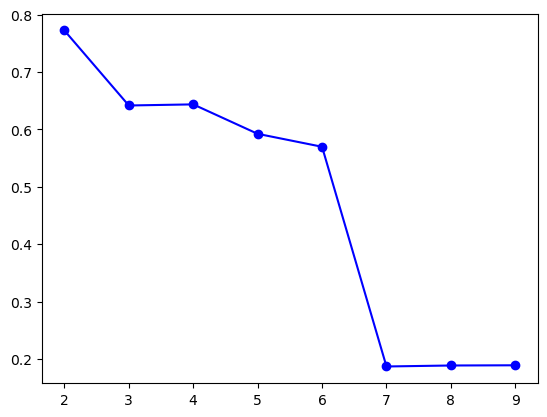

In [16]:
from sklearn.metrics import silhouette_score

silhouette_scores = [silhouette_score(X, model.labels_) for model in kmeans_per_k[1:]]
plt.plot(range(2, 10), silhouette_scores, "bo-")

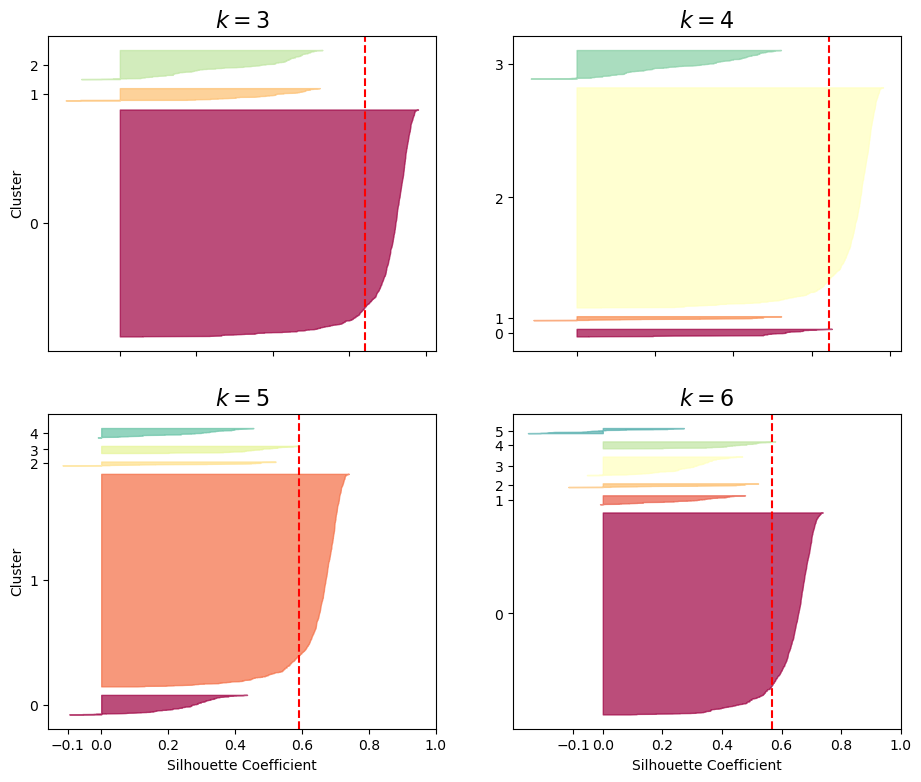

In [17]:
import matplotlib as mpl
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

plt.figure(figsize=(11, 9))

for k in (3, 4, 5, 6):
    plt.subplot(2, 2, k - 2)

    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(X, y_pred)

    padding = len(X) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")

    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)

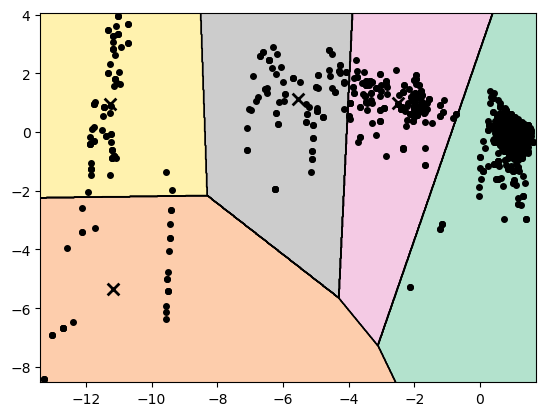

In [18]:
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
data = kmeans.fit(X_pca[:,:2])
plot_decision_boundaries(kmeans,X_pca[:,:2])

In [19]:
from sklearn.model_selection import train_test_split

np.random.seed(42)
X_train, X_test, y_train, y_test = train_test_split(X, Y, stratify=Y, test_size=0.2, random_state=42)

In [20]:
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, roc_curve, roc_auc_score, f1_score, r2_score, mean_absolute_error, mean_squared_error, accuracy_score
from sklearn.model_selection import cross_val_predict, cross_val_score

lscores = []

def result(model, model_reg):
    predicciones = model_reg.predict(X_test)
    y_train_pred = cross_val_predict(model_reg, X_train, y_train, cv=3)
    lscores.append({
        "name" : model,
        "f1" : round(f1_score(y_train, y_train_pred), 4),
        "r2" : round(r2_score(y_test, predicciones), 4),
        "accuracy" : round(accuracy_score(y_train, y_train_pred), 4),
        "precission" : round(precision_score(y_train, y_train_pred), 4),
        "recall" : round(recall_score(y_train, y_train_pred), 4),
        "error_mse" : np.sqrt(mean_squared_error(y_test, predicciones)),
        "model_score" : cross_val_score(model_reg, X_train, y_train, cv=3, scoring="accuracy"),
        "error_mae" : mean_absolute_error(y_test, predicciones)
    })


def acc_rec_graph(models):
    plt.figure(figsize=(10,8))
    for name, model in models.items():
        try:
            y_scores = cross_val_predict(model, X_train, y_train, cv=3, method="decision_function")
            precisions, recalls, _ = precision_recall_curve(y_train, y_scores)
            plt.plot(recalls, precisions, label=name, linewidth=2)
        except AttributeError:
            print(f"{name} no tiene el metodo decision_function")

    plt.title("Precision/recall")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend()

def roc_graph(models):
    plt.figure(figsize=(10,8))
    for i, (name, model) in enumerate(models.items()):
        y_scores = cross_val_predict(model, X_train, y_train, cv=3, method="predict_proba")
        y_scores = y_scores[:,1]
        fpr, tpr, _ = roc_curve(y_train, y_scores)
        plt.plot(fpr, tpr, label=name)
        lscores[i]["roc_auc_score"] = round(roc_auc_score(y_train, y_scores), 4)
    
    plt.title("ROC curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend()


# TODO generalizacion del metodo
def prerec_curve(models):
    plt.figure(figsize=(10,8))
    fig, axes = plt.subplots(2, 3) # se que solo 5 van a funcionar por eso el TODO
    
    pos=0
    for name, model in models.items():
        try:
            y_scores = cross_val_predict(model, X_train, y_train, cv=3,
                             method="decision_function")
            precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores, pos_label=1)

            axes.flatten()[pos].plot(thresholds, precisions[:-1], "b", label="Precision", linewidth=2)
            axes.flatten()[pos].plot(thresholds, recalls[:-1], "g", label="Recall", linewidth=2)
            axes.flatten()[pos].set_title(name)
            axes.flatten()[pos].legend()
            pos+=1
        except Exception as err:
            print(f"{name}----{err}")
           
    fig.set_figheight(10)
    fig.set_figwidth(15)
    fig.tight_layout()
    axes.flatten()[-1].set_axis_off()

In [21]:
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

models = {
    "SGDClassifier": SGDClassifier("log_loss"),
    "Logistic Regression": LogisticRegression(solver="lbfgs", max_iter=10000),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(probability=True),
    "Gradient Boosting": GradientBoostingClassifier(),
    "XGBoost": XGBClassifier(),
    "AdaBoost": AdaBoostClassifier(), 
    "Naive Bayes": GaussianNB(),       
    "MLP Neural Network": MLPClassifier(max_iter=1000) 
}

In [22]:
for name, model in models.items():
    model.fit(X_train, y_train)
    result(name, model)

c:\Users\nicol\miniconda3\envs\ia\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\nicol\miniconda3\envs\ia\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\nicol\miniconda3\envs\ia\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\nicol\miniconda3\envs\ia\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this wa

Decision Tree----'DecisionTreeClassifier' object has no attribute 'decision_function'
Random Forest----'RandomForestClassifier' object has no attribute 'decision_function'
XGBoost----'XGBClassifier' object has no attribute 'decision_function'


c:\Users\nicol\miniconda3\envs\ia\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\nicol\miniconda3\envs\ia\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\nicol\miniconda3\envs\ia\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Naive Bayes----'GaussianNB' object has no attribute 'decision_function'
MLP Neural Network----'MLPClassifier' object has no attribute 'decision_function'


<Figure size 1000x800 with 0 Axes>

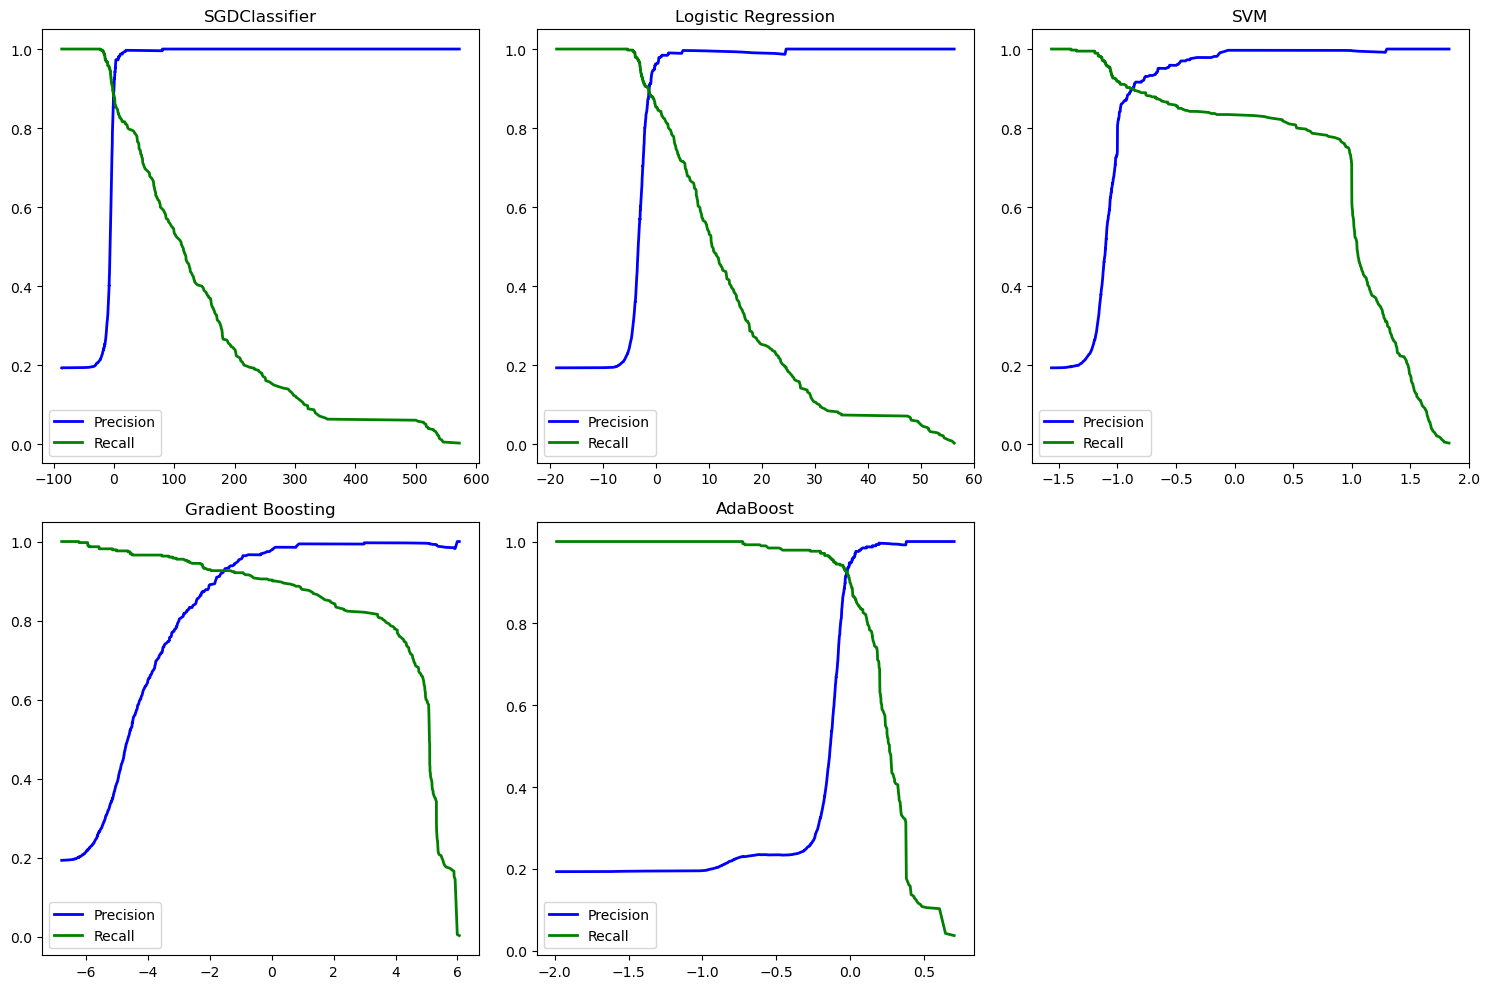

In [23]:
prerec_curve(models)

Decision Tree no tiene el metodo decision_function
Random Forest no tiene el metodo decision_function
XGBoost no tiene el metodo decision_function


c:\Users\nicol\miniconda3\envs\ia\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\nicol\miniconda3\envs\ia\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\nicol\miniconda3\envs\ia\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Naive Bayes no tiene el metodo decision_function
MLP Neural Network no tiene el metodo decision_function


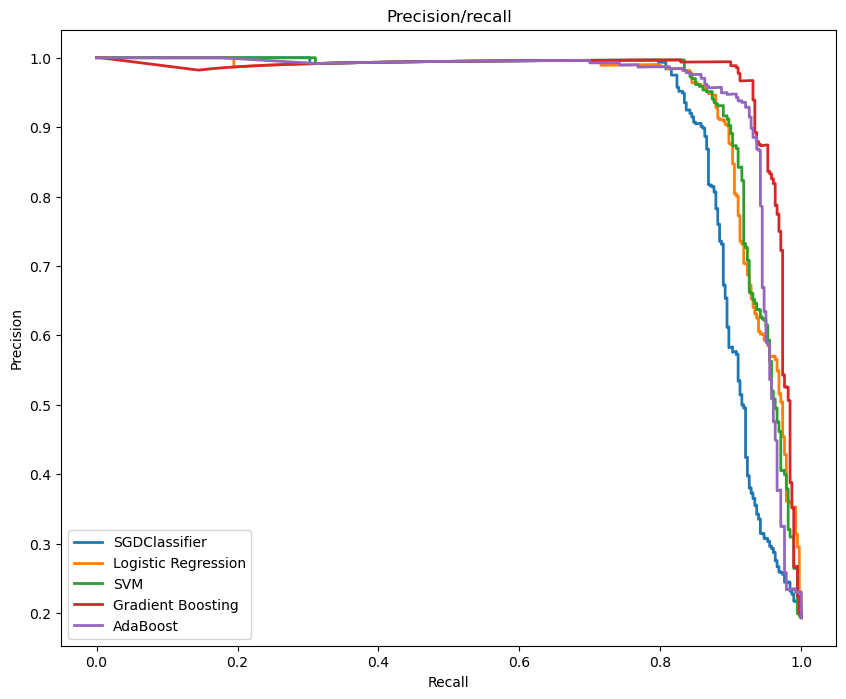

In [24]:
acc_rec_graph(models)

c:\Users\nicol\miniconda3\envs\ia\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\nicol\miniconda3\envs\ia\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\nicol\miniconda3\envs\ia\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


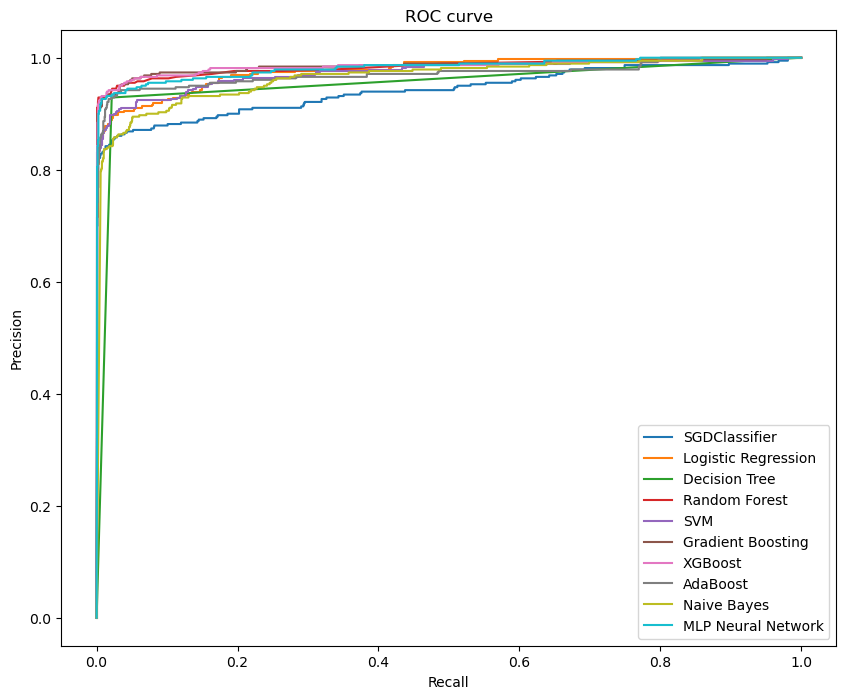

In [25]:
roc_graph(models)

In [26]:
df = pd.DataFrame(lscores)
df

,name,f1,r2,accuracy,precission,recall,error_mse,model_score,error_mae,roc_auc_score
0,SGDClassifier,0.9066,0.7000,0.9654,0.9483,0.8684,0.216213,"[0.9329268292682927, 0.9603658536585366, 0.960...",0.046748,0.9419
1,Logistic Regression,0.9050,0.8435,0.9654,0.9643,0.8526,0.156174,"[0.9634146341463414, 0.961890243902439, 0.9710...",0.024390,0.9771
2,Decision Tree,0.9086,0.8304,0.9639,0.8892,0.9289,0.162551,"[0.9695121951219512, 0.9664634146341463, 0.967...",0.026423,0.9538
3,Random Forest,0.9523,0.9217,0.9822,0.9887,0.9184,0.110432,"[0.9817073170731707, 0.9832317073170732, 0.980...",0.012195,0.9834
4,SVM,0.9067,0.8304,0.9670,0.9968,0.8316,0.162551,"[0.9679878048780488, 0.9679878048780488, 0.964...",0.026423,0.9736
5,Gradient Boosting,0.9410,0.8956,0.9782,0.9828,0.9026,0.127515,"[0.9817073170731707, 0.9801829268292683, 0.977...",0.016260,0.9849
6,XGBoost,0.9499,0.9087,0.9812,0.9777,0.9237,0.119280,"[0.9801829268292683, 0.9832317073170732, 0.980...",0.014228,0.9844
7,AdaBoost,0.9216,0.8695,0.9705,0.9472,0.8974,0.142566,"[0.9710365853658537, 0.9725609756097561, 0.967...",0.020325,0.9711
8,Naive Bayes,0.8812,0.7782,0.9563,0.9273,0.8395,0.185884,"[0.9557926829268293, 0.9557926829268293, 0.957...",0.034553,0.9644
9,MLP Neural Network,0.9394,0.9087,0.9771,0.9614,0.9184,0.119280,"[0.9771341463414634, 0.9801829268292683, 0.974...",0.014228,0.9821


In [27]:
for name, model in models.items():
    predicciones = model.predict(X_test)

    errores=0
    for i, prediccion in enumerate(predicciones):
        if prediccion != list(y_test)[i]:
            errores+=1
    print(f"{name} FALLA EN: {errores} de {len(X_test)} con: {round(errores/len(X_test)*100, 2)}% de errores")

SGDClassifier FALLA EN: 23 de 492 con: 4.67% de errores
Logistic Regression FALLA EN: 12 de 492 con: 2.44% de errores
Decision Tree FALLA EN: 13 de 492 con: 2.64% de errores
Random Forest FALLA EN: 6 de 492 con: 1.22% de errores
SVM FALLA EN: 13 de 492 con: 2.64% de errores
Gradient Boosting FALLA EN: 8 de 492 con: 1.63% de errores
XGBoost FALLA EN: 7 de 492 con: 1.42% de errores
AdaBoost FALLA EN: 10 de 492 con: 2.03% de errores
Naive Bayes FALLA EN: 17 de 492 con: 3.46% de errores
MLP Neural Network FALLA EN: 7 de 492 con: 1.42% de errores
